In [3]:
# LM model imports 
import os
import time
import torch
from torch import optim
from models.context2vec.src.eval.mscc import mscc_evaluation
from models.context2vec.src.core.nets import Context2vec
from models.context2vec.src.util.args import parse_args
from models.context2vec.src.util.batch import Dataset
from models.context2vec.src.util.config import Config
from models.context2vec.src.util.io import write_embedding, write_config, read_config, load_vocab


# OCR model imports 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import itertools
from models.ocr.src.config import letters


# TODO 
# -- need to add if the model is not loaded -- error print statement 


# LM model imports 
import os
import time
import torch
from torch import optim
from models.context2vec.src.eval.mscc import mscc_evaluation
from models.context2vec.src.core.nets import Context2vec
from models.context2vec.src.util.args import parse_args
from models.context2vec.src.util.batch import Dataset
from models.context2vec.src.util.config import Config
from models.context2vec.src.util.io import write_embedding, write_config, read_config, load_vocab


# OCR model imports 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import itertools
from models.ocr.src.config import letters

from collections import defaultdict
from operator import itemgetter



class Inference():
    def __init__(self, modelfile=None, wordsfile=None, img_width=128, img_height=64, device='cpu'):
        
        self.device = device
        self.img_width = img_width
        self.img_height = img_height
        self.build_language_model()
        self.build_ocr_model()
        
    def build_language_model(self):
        # LANGUAGE MODEL
        modelfile = 'models/context2vec/models/model.param'
        wordsfile = 'models/context2vec/models/embedding.vec'
        config_file = modelfile+'.config.json'
        config_dict = read_config(config_file)
        self.lm_model = Context2vec(vocab_size=config_dict['vocab_size'],
                            counter=[1]*config_dict['vocab_size'],
                            word_embed_size=config_dict['word_embed_size'],
                            hidden_size=config_dict['hidden_size'],
                            n_layers=config_dict['n_layers'],
                            bidirectional=config_dict['bidirectional'],
                            use_mlp=config_dict['use_mlp'],
                            dropout=config_dict['dropout'],
                            pad_index=config_dict['pad_index'],
                            device=self.device,
                            inference=True).to(self.device)
        self.lm_model.load_state_dict(torch.load(modelfile, map_location=self.device))
#         optimizer = optim.Adam(model.parameters(), lr=config_dict['learning_rate'])
        # optimizer.load_state_dict(torch.load(modelfile+'.optim'))
        self.itos, self.stoi = load_vocab(wordsfile)
        self.unk_token = config_dict['unk_token']
        self.bos_token = config_dict['bos_token']
        self.eos_token = config_dict['eos_token']

        
    def build_ocr_model(self):
        self.sess = tf.Session()
        K.set_session(self.sess)

        ocr_model_path = 'models/ocr/models/weights-improvement2-10-01-3.00.hdf5'
        self.ocr_model = load_model(ocr_model_path, custom_objects={'<lambda>': lambda y_true, y_pred: y_pred})
        
    def preprocess_image(self, img_path, img_width, img_height):
        img = cv2.imread(img_path)
        # grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # resize image
        img = cv2.resize(img, (img_width, img_height))
        # change image type
        img = img.astype(np.float32)
        # scale image 
        img /= 255
        img = img.reshape((1, img_width, img_height, 1))
        return img
        
        
    def _decode_batch(self, out):
        ret = []
        for j in range(out.shape[0]):
            out_best = list(np.argmax(out[j, 2:], 1))
            out_best = [k for k, g in itertools.groupby(out_best)]
            outstr = ''
            for c in out_best:
                if c < len(letters):
                    outstr += letters[c]
            ret.append(outstr)
        return ret

        
    def _return_split_sentence(self, sentence):
        if ' ' not in sentence:
            print('sentence should contain white space to split it into tokens')
            raise SyntaxError
        elif '[]' not in sentence:
            print('sentence should contain `[]` that notes the target')
            raise SyntaxError
        else:
            tokens = sentence.lower().strip().split()
            target_pos = tokens.index('[]')
            return tokens, target_pos
        
    def run_lm_inference_by_user_input(self, sentence, topK=30):

        # evaluation mode 
        self.lm_model.eval()
        # norm_weight
        self.lm_model.norm_embedding_weight(self.lm_model.criterion.W)

        tokens, target_pos = self._return_split_sentence(sentence)
        tokens[target_pos] = self.unk_token
        tokens = [self.bos_token] + tokens + [self.eos_token]
        indexed_sentence = [self.stoi[token] if token in self.stoi else self.stoi[self.unk_token] for token in tokens]
        input_tokens = \
            torch.tensor(indexed_sentence, dtype=torch.long, device=self.device).unsqueeze(0)
        topv, topi = self.lm_model.run_inference(input_tokens, target=None, target_pos=target_pos, k=topK)
        output = []  
        for value, key in zip(topv, topi):
            output.append((value.item(), self.itos[key.item()]))
#             print(value.item(), self.itos[key.item()])
        return output
    
    def run_ocr_inference_by_user_image(self, img):
        net_inp = self.ocr_model.get_layer(name='the_input').input
        net_out = self.ocr_model.get_layer(name='softmax').output
        net_out_value = self.sess.run(net_out, feed_dict={net_inp: img})
        pred_texts = self._decode_batch(net_out_value)
        return pred_texts
    
    from collections import defaultdict
    from operator import itemgetter


    def create_features(self, lm_preds, ocr_pred):

        # not used currently
        # ----------------------------------
        bins = {
            'small': list(range(0, 3)),
            'small-mid': list(range(2, 6)),
            'mid': list(range(4, 8)),
            'mid-large': list(range(6, 10)),
            'large': list(range(8, 12)),
            'large-big': list(range(10, 14)),
            'big': list(range(12, 100)),
        }

        bins = defaultdict(lambda: 'na', bins)

        ocr_len = len([x for x in ocr_pred[0]])
        pred_bins = [k for k, v in bins.items() if ocr_len in v]
        # ----------------------------------

        features = {}
        bad_list = ['<PAD>', '<BOS>', '<EOS>', '<UNK>'] # ADD foul words
        matches = {}
        matches_non_ordered = {}

        ocr_pred_lower = ocr_pred[0].lower()

        for lm_pred in lm_preds:
            score, word = lm_pred[0], lm_pred[1].rstrip()
            word = word.lower()
            # remove pad, bos, etc...
            if word not in bad_list:
                try:
                    features[word] = {}
                    features[word]['score'] = score
                    # match first and last character 
                    first_char_match = word[0] == ocr_pred_lower[0]
                    last_char_match = word[-1] == ocr_pred_lower[-1]
                    features[word]['first_char_match'] = first_char_match
                    features[word]['last_char_match'] = last_char_match

                    num_chars = 0
                    for char in ocr_pred_lower:
                        if char in word:
                            num_chars += 1
                        matches[word] = num_chars
                    features[word]['num_matches'] = matches[word] 
                except:
                    pass 

        return features


    def final_scores(self, features):
        final_scores = {}

        for word, feature_dict in features.items():
            final_score = 1
            first_char_match = feature_dict['first_char_match']
            last_char_match = feature_dict['last_char_match']
            score = feature_dict['score']
            if first_char_match:
                final_score += 10
            if last_char_match:
                final_score += 10
            final_score *= score
            final_scores[word] = final_score
        top_results = sorted(final_scores.items(), key=itemgetter(1), reverse=True)
        return top_results[0][0]

    def weigh_function(self):
        pass
    
    
    def predict(self, sentence, img_path):
        lm_preds = self.run_lm_inference_by_user_input(sentence)
        print('lm_preds', lm_preds)
        img = self.preprocess_image(img_path, self.img_width, self.img_height)
        ocr_pred = self.run_ocr_inference_by_user_image(img)
        print('ocr_pred', ocr_pred)

        features = self.create_features(lm_preds, ocr_pred)
        final_pred = self.final_scores(features)
    
        # return top K? And use MAP @ K ??
        return final_pred


if __name__ == '__main__':
    left_text = 'the dog ran'
    right_text = 'the house'

    sentence = left_text + ' [] ' + right_text

    img_width = 128
    img_height = 64
    img_path = '../../data/sample/c03-096f-03-05.png'


    inference = Inference()

    print(inference.predict(sentence, img_path))

lm_preds [(0.8051942586898804, 'into'), (0.5680796504020691, 'above'), (0.2566736936569214, 'through'), (0.0, '<PAD>'), (0.0, '<BOS>'), (0.0, '<EOS>'), (-0.0033715423196554184, 'against'), (-0.0241890586912632, 'across'), (-0.09841558337211609, 'alongside'), (-0.25158366560935974, 'from'), (-0.2979653775691986, '<UNK>'), (-0.39155226945877075, 'onto'), (-0.42664194107055664, '-'), (-0.5151805281639099, 'along'), (-0.5289998650550842, 'down'), (-0.6323362588882446, 'past'), (-0.6823214888572693, 'beside'), (-0.7862836718559265, 'behind'), (-0.7909708023071289, 'to'), (-0.8059641718864441, 'off'), (-0.8149632811546326, 'throughout'), (-0.8522829413414001, 'towards'), (-0.8726194500923157, 'near'), (-1.0634551048278809, 'beyond'), (-1.0821455717086792, 'inhabiting'), (-1.1535910367965698, 'woven'), (-1.1612988710403442, 'under'), (-1.1739630699157715, 'Hugh'), (-1.2416491508483887, 'wars'), (-1.327302098274231, 'inside')]
ocr_pred ['o']
into


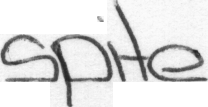

In [6]:
from PIL import Image

Image.open('../../data/sample/c03-096f-03-05.png')

In [ ]:
!pip uninstall opencv-python

In [1]:
import cv2

In [2]:
cv2.__version__

'3.4.0'